# DBSCAN

In [33]:
import random
import numpy as np
import pandas as pd

In [34]:
from scipy.spatial.distance import cdist
def get_distance_matrix(X):
    dist_mat = cdist(X, X, metric="minkowski", p=1)
    return pd.DataFrame(dist_mat)

In [35]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y, z = df.iloc[index]['X']  ,  df.iloc[index]['Y'] , df.iloc[index]['Z']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)  & (np.abs(z - df['Z']) <= eps)) & (df.index != index)]
    
    print(f"Points in radius: {len(temp)}")
    #check how many points are present within radius
    if len(temp) >= minPts:
        print(f" ==> Core point")
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        print(f"==> Border point")
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        print(f"==> Noise")
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    print(f"Initial cluster number: {C}")
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    border_pts = []
    core_pts = []
    noise_pts = []
    
    print("visit all points:")
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        rand_unvis = random.choice(unvisited)
        current_stack.add(rand_unvis)
        print(f"Random unvisited point: {rand_unvis}")
        
        while len(current_stack) != 0: #run until a cluster is complete
            print(f"Nr of elements in stack: {len(current_stack)}")
            #pop current point from stack
            curr_idx = current_stack.pop()
            print(f"======================================")
            print(f"Next point from stack: {curr_idx}, {df.loc[[curr_idx]].values.tolist()}")
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                print("First border point => label it and its neighbours as noise")
                #for first border point, we label it and its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                print(f"Noise/0 := {curr_idx}, {neigh_indexes} ")
                #label as visited
                print("Mark point and neighbours as visited")
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
            print("Mark point as visited")    
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            print("Discard visited points in neighbourhood:")  
            print(f"{neigh_indexes.tolist()} => {set(neigh_indexes) & set(unvisited)}")
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                print(f"Point {curr_idx} to cluster C{C}")
                clusters.append((curr_idx,C)) #assign to a cluster
                print(f"Put unvisited neighbours on stack")
                current_stack.update(neigh_indexes) #add neighbours to a stack
                core_pts.append(curr_idx)
                
            elif isborder: #if current point is a border point
                print(f"Point {curr_idx} to cluster C{C}")
                clusters.append((curr_idx,C))
                border_pts.append(curr_idx)
                
                continue

            elif isnoise: #if current point is noise
                print(f"Noise {curr_idx} to noise C0")
                clusters.append((curr_idx, 0))
                noise_pts.append(curr_idx)
                
                continue
        print(f"======================================")
        print(f"No more points in stack")        
        if not first_point and (len(unvisited) != 0):
            #increment cluster number
            C+=1
            print(f"Increment cluster number to: {C}")  
    print(f"======================================")
    print(f"All points visited!") 
    print(f"Total number of clusters: {C}") 
    print(f"Core points: {core_pts}") 
    print(f"Border points: {border_pts}") 
    print(f"Noise points: {noise_pts}") 
    return clusters

In [36]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

centers = [(0, 4), (5, 5) , (8,2)]
cluster_std = [1.2, 1, 1.1]

#Data
X = np.array([[1,1],  #A
              [2,1],  #B
              [1,2],  #C
              [2,2],  #D
              [3,5],  #E
              [3,9],  #F
              [3,10], #G
              [4,10],  #H
              [4,11],  #I
              [5,10],  #J
              [7,10],  #K
              [10,9],  #L
              [10,6],  #M
              [9,5],  #N
              [10,5],  #O
              [11,5],  #P
              [9,4],  #Q
              [10,4],  #R
              [11,4],  #S
              [10,3]])  #T

X = np.array([[3,1,0],
              [2,0,1],
              [2,1,0],
              [8,8,9],
              [9,9,9],
              [5,9,8]])

df = pd.DataFrame(data=X,columns=["X", "Y", "Z"])
print(df)

get_distance_matrix(X)

   X  Y  Z
0  3  1  0
1  2  0  1
2  2  1  0
3  8  8  9
4  9  9  9
5  5  9  8


,0,1,2,3,4,5
0,0.0,3.0,1.0,21.0,23.0,18.0
1,3.0,0.0,2.0,22.0,24.0,19.0
2,1.0,2.0,0.0,22.0,24.0,19.0
3,21.0,22.0,22.0,0.0,2.0,5.0
4,23.0,24.0,24.0,2.0,0.0,5.0
5,18.0,19.0,19.0,5.0,5.0,0.0


eps=2, minPts=2
Initial cluster number: 1
visit all points:
Random unvisited point: 2
Nr of elements in stack: 1
Next point from stack: 2, [[2, 1, 0]]
Points in radius: 2
 ==> Core point
Mark point as visited
Discard visited points in neighbourhood:
[0, 1] => {0, 1}
Point 2 to cluster C1
Put unvisited neighbours on stack
Nr of elements in stack: 2
Next point from stack: 0, [[3, 1, 0]]
Points in radius: 2
 ==> Core point
Mark point as visited
Discard visited points in neighbourhood:
[1, 2] => {1}
Point 0 to cluster C1
Put unvisited neighbours on stack
Nr of elements in stack: 1
Next point from stack: 1, [[2, 0, 1]]
Points in radius: 2
 ==> Core point
Mark point as visited
Discard visited points in neighbourhood:
[0, 2] => set()
Point 1 to cluster C1
Put unvisited neighbours on stack
No more points in stack
Increment cluster number to: 2
Random unvisited point: 4
Nr of elements in stack: 1
Next point from stack: 4, [[9, 9, 9]]
Points in radius: 1
==> Border point
First border point => la

Text(0.5, 0.5, 'Y')

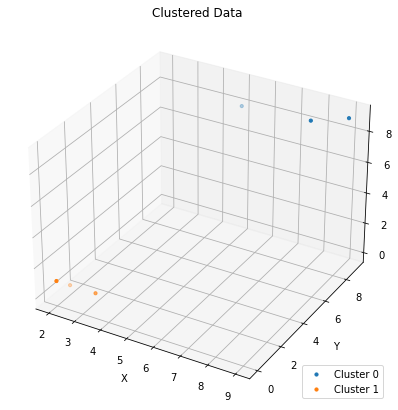

In [37]:
#radius of the circle defined as 0.6
eps = 2
#minimum neighbouring points set to 3
minPts = 2

print(f"eps={eps}, minPts={minPts}")
data = df
clustered = cluster_with_stack(eps, minPts, data)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

print(f"Point/Cluster assignments:")
print(cluster_df)

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection ="3d")
for clust in np.unique(cluster):
    ax.scatter3D(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 2],s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')